In [1]:
import random

import matplotlib as mpl
import numpy as np
import torch
import torch.utils.data

import theseus as th
import theseus.utils.examples as theg

%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.double)

device = "cuda:0" if torch.cuda.is_available else "cpu"
seed = 0
torch.random.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["font.size"] = 16

In [2]:
!pwd

/home/peteryu/SEANRobotGuide/demo


In [2]:
dataset_dir = "/home/peteryu/SEANRobotGuide/data/motion-planning-2d/dataset"
train_dataset = theg.TrajectoryDataset(True, 1000, dataset_dir, val_ratio=0.2, map_type="tarpit", filter_collision_maps=True)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = theg.TrajectoryDataset(False, 1000, dataset_dir, val_ratio=0.2, map_type="tarpit", filter_collision_maps=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

print(len(train_dl))

batch = next(iter(train_dl))
print(batch.keys())
for k, v in batch.items():
    if k != "file_id":
        print(f"{k:20s}: {v.shape}")
    else:
        print(f"{k:20s}: {v}")

23
dict_keys(['map_tensor', 'sdf_origin', 'cell_size', 'sdf_data', 'expert_trajectory', 'file_id'])
map_tensor          : torch.Size([32, 128, 128])
sdf_origin          : torch.Size([32, 2])
cell_size           : torch.Size([32, 1])
sdf_data            : torch.Size([32, 128, 128])
expert_trajectory   : torch.Size([32, 4, 101])
file_id             : ['tarpit_15', 'tarpit_682', 'tarpit_244', 'tarpit_598', 'tarpit_317', 'tarpit_970', 'tarpit_940', 'tarpit_303', 'tarpit_683', 'tarpit_117', 'tarpit_150', 'tarpit_242', 'tarpit_664', 'tarpit_985', 'tarpit_696', 'tarpit_971', 'tarpit_710', 'tarpit_648', 'tarpit_181', 'tarpit_719', 'tarpit_190', 'tarpit_288', 'tarpit_668', 'tarpit_105', 'tarpit_941', 'tarpit_75', 'tarpit_201', 'tarpit_95', 'tarpit_229', 'tarpit_35', 'tarpit_55', 'tarpit_631']


/tmp/ipykernel_3481286/390792042.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[0].show()


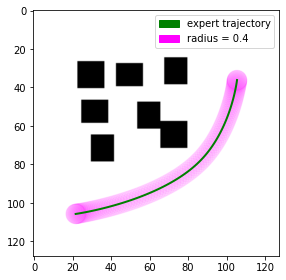

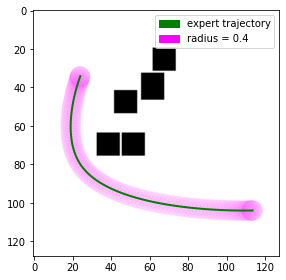

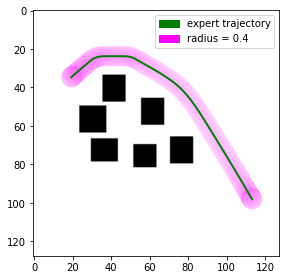

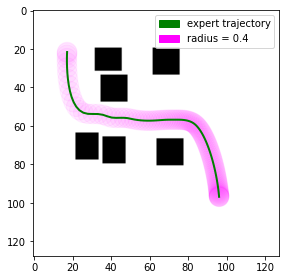

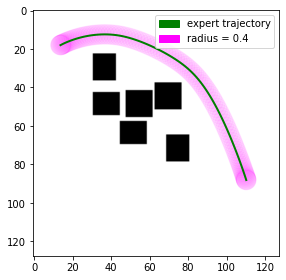

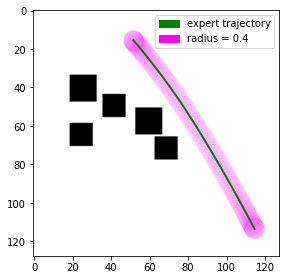

In [45]:
sdf = th.eb.SignedDistanceField2D(
    th.Point2(batch["sdf_origin"]),
    th.Variable(batch["cell_size"]),
    th.Variable(batch["sdf_data"]),
)

i = 0
for batch in train_dl:
    
    sdf = th.eb.SignedDistanceField2D(
        th.Point2(batch["sdf_origin"][0].unsqueeze(0)),
        th.Variable(batch["cell_size"][0].unsqueeze(0)),
        th.Variable(batch["sdf_data"][0].unsqueeze(0)),
    )
    
    figs = theg.generate_trajectory_figs(
        batch["map_tensor"][0].unsqueeze(0), 
        sdf, 
        [batch["expert_trajectory"][0].unsqueeze(0)],
        robot_radius=0.4, 
        labels=["expert trajectory"], 
        fig_idx_robot=0,
        figsize=(10, 4),
    )
    
    figs[0].show()
    
    if i == 5:
        break
    i+=1

In [3]:
# Constant for optimization
# trajectory_len = batch["expert_trajectory"].shape[2]
# num_time_steps = trajectory_len - 1
# map_size = batch["map_tensor"].shape[1]
safety_distance = 0.4
robot_radius = 0.4
total_time = 10.0
# dt_val = total_time / num_time_steps
Qc_inv = [[1.0, 0.0], [0.0, 1.0]]
collision_w = 20.0
boundary_w = 100.0

In [4]:
# Check if every trial as the same number of time steps
trial_count = 0
broken_count = 0
for trial in train_dl:
    if trial["expert_trajectory"].size() != (64, 4, 101):
        broken_count += 1
    trial_count += 1

print(trial_count, broken_count)

23 23


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=1, output_dim=99*2, batchsize=32):
        super().__init__()
        self.batchsize = batchsize
        
        self.without_start_goal = nn.Sequential(
            nn.Conv2d(input_dim, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3,stride=2),
            
            nn.Conv2d(64, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        
        self.project_start_and_goal = nn.Sequential(
            nn.Linear(4,8),
            nn.ReLU(inplace=True),
            nn.Linear(8,16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(16,32),
        )
        
        self.conv_dim = 5408
        
        self.project_down = nn.Sequential(
            nn.Linear(self.conv_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
        )

        
        self.middle_dim = 64 + 32
        self.fc1 = nn.Linear(self.middle_dim, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, map_info, start_and_goal, verbose=False):
        map_info = self.without_start_goal(map_info)
        map_info = (map_info.reshape(self.batchsize, 1, -1))
        if verbose:
            print("After first set of conv layers: ", map_info.size())
        map_info = self.project_down(map_info)
        
        start_and_goal = self.project_start_and_goal(start_and_goal)
        if verbose:
            print("Projected start and goal:", start_and_goal.size())
        
        output = torch.cat((map_info, start_and_goal), 2)
        if verbose:
            print("Concatenated: ", output.size())
                
        return self.fc2(self.dropout(F.relu(self.fc1(output))))


In [6]:
def prepare_training_data(batch, batchsize=32, include_sdf=False):
    map_tensor = batch["map_tensor"].unsqueeze(1).to(device)
    sdf_tensor = batch["sdf_data"].unsqueeze(1).to(device)
    expert_traj = batch["expert_trajectory"].to(device)
    label_traj = expert_traj[:, :2, 1:-1].reshape(batchsize, 1, -1)
    
    start = expert_traj[:, :2, 0]
    goal = expert_traj[:, :2, -1]
    start_and_goal = torch.cat((start, goal), 1).unsqueeze(1).to(device)
    
    if include_sdf:
        map_tensor = torch.cat((map_tensor, sdf_tensor), 1).double()
    else:
        map_tensor = map_tensor.double()
    
    return map_tensor, start_and_goal, label_traj

def loss_func(feat1, feat2):
    # maximize average magnitude of cosine similarity
    loss = nn.MSELoss()
    return loss(feat1, feat2)

In [10]:
net = CNN(input_dim=1, output_dim=198, batchsize=32).to(device)
with torch.no_grad():
    ex_batch = next(iter(train_dl))
    # print(ex_trial["expert_trajectory"])
    map_tensor, start_and_goal, label_traj = prepare_training_data(ex_batch, include_sdf=False)
    # print(start_and_goal)
    # rint(label_traj.size())
    out = net(map_tensor, start_and_goal, verbose=True)
    print(out.size(), out.requires_grad)

After first set of conv layers:  torch.Size([32, 1, 5408])
Projected start and goal: torch.Size([32, 1, 32])
Concatenated:  torch.Size([32, 1, 96])
torch.Size([32, 1, 198]) False


In [11]:
torch.cuda.empty_cache()

In [72]:
from torch.utils.tensorboard import SummaryWriter

In [12]:
from copy import deepcopy

In [74]:
# tensorboard --log_dir runs

In [13]:
# Training loop
# writer = SummaryWriter()

from torch.optim.lr_scheduler import StepLR
include_sdf = False
batchsize = 32

net = CNN(input_dim=1+include_sdf, output_dim=198).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
net.train()
# epochs = 50

epoch = 1
train_losses, test_losses = [], []
count = 0
best_model = None
early_stopping_val = 50

while epoch <= 2:
    epoch_train_losses, epoch_test_losses = [], []
    net.train()
    for batch in train_dl:
        map_tensor, start_and_goal, label_traj = prepare_training_data(batch, batchsize=batchsize, include_sdf=include_sdf)
        net.zero_grad()
        traj = net(map_tensor, start_and_goal)
        print(traj.requires_grad)
        loss = loss_func(traj, label_traj)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss)
        print(loss.requires_grad)

    net.eval()
    with torch.no_grad():
        for batch in test_dl:
            map_tensor, start_and_goal, label_traj = prepare_training_data(batch, batchsize=batchsize, include_sdf=include_sdf)
            traj = net(map_tensor, start_and_goal)
            loss = loss_func(traj, label_traj)
            epoch_test_losses.append(loss)
    
    train_loss = sum(epoch_train_losses)/len(epoch_train_losses)
    test_loss = sum(epoch_test_losses)/len(epoch_test_losses)
    
    
    if len(test_losses) and test_loss < min(test_losses):
        best_model = deepcopy(net)
        count = 0
    else:
        count +=1
        if count > early_stopping_val:
            print("Early Stopping")
            break
    
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    scheduler.step()
    if epoch % 5 == 0:
        print("Epoch {}, train loss {:.4f}, test loss {:.4f}".format(epoch, train_loss, test_loss))
    
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/test", test_loss, epoch)
    
    epoch += 1
    

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


NameError: name 'writer' is not defined

tensor(2.6731, device='cuda:0')
tensor(10.2250, device='cuda:0')


/tmp/ipykernel_3481286/1619059915.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[0].show()


tensor(3.0089, device='cuda:0')
tensor(2.2640, device='cuda:0')
tensor(2.0472, device='cuda:0')
tensor(2.8455, device='cuda:0')


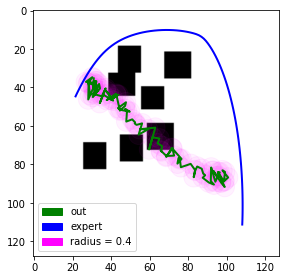

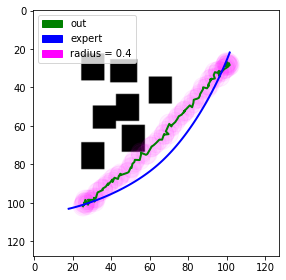

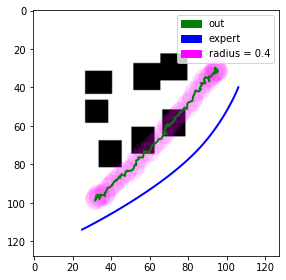

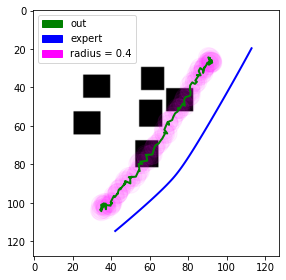

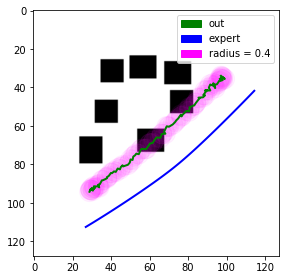

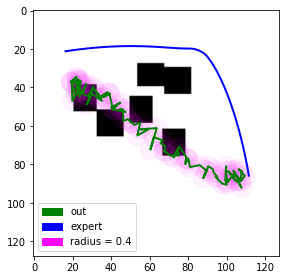

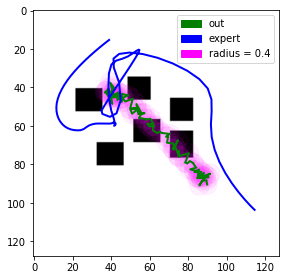

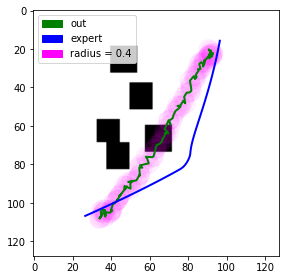

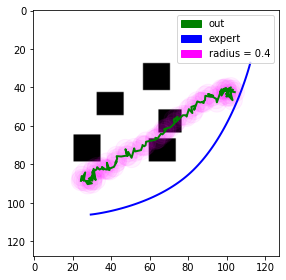

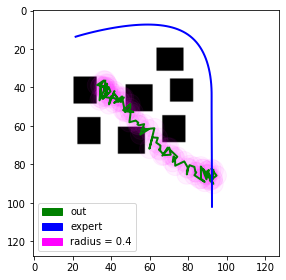

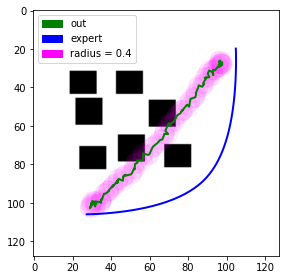

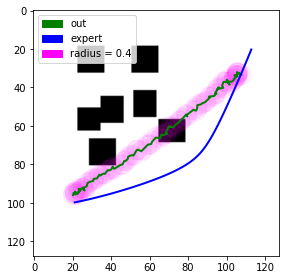

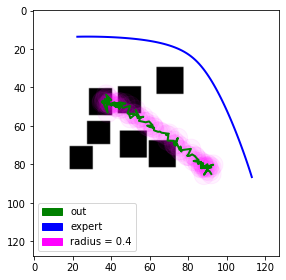

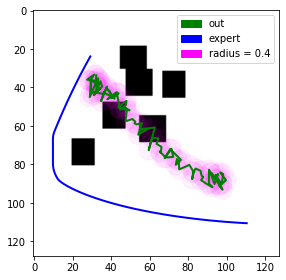

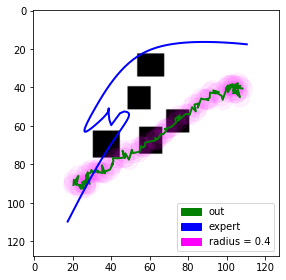

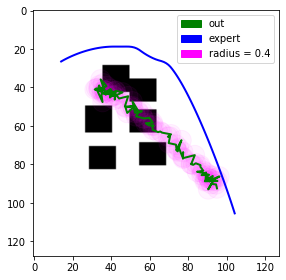

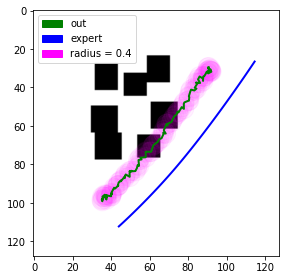

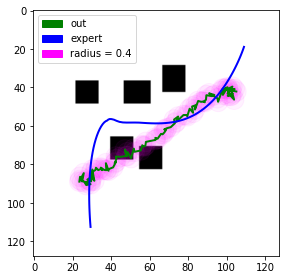

In [79]:
# print out inferred path
net.eval()
i = 1
num_examples = 3
sdf = th.eb.SignedDistanceField2D(
    th.Point2(batch["sdf_origin"]),
    th.Variable(batch["cell_size"]),
    th.Variable(batch["sdf_data"]),
)

for batch in test_dl:
    with torch.no_grad():
        map_tensor, start_and_goal, label_traj = prepare_training_data(batch)
        out = net(map_tensor, start_and_goal)
        print(loss_func(out, label_traj))
        
        for i in range(num_examples):
            path = out.reshape(32, 2, 99).detach().to("cpu")
            sdf = th.eb.SignedDistanceField2D(
                th.Point2(batch["sdf_origin"][i].unsqueeze(0)),
                th.Variable(batch["cell_size"][i].unsqueeze(0)),
                th.Variable(batch["sdf_data"][i].unsqueeze(0)),
            )

            figs = theg.generate_trajectory_figs(
                batch["map_tensor"][i].unsqueeze(0), 
                sdf, 
                [path[i].unsqueeze(0), batch["expert_trajectory"][i].unsqueeze(0)],
                robot_radius=0.4, 
                labels=["out", "expert"], 
                fig_idx_robot=0,
                figsize=(10, 4),
            )

            figs[0].show()
